In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from sklearn.metrics import mean_squared_error


In [48]:
tf.random.set_seed(123)
data = pd.read_excel("CONSUMO-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

consume_data = data['Gasolina superior'].to_frame()
consume_data
print(type(consume_data))

<class 'pandas.core.frame.DataFrame'>


In [49]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(consume_data.index, pd.DatetimeIndex):
    consume_data.index = pd.to_datetime(consume_data.index)

# Group the data by year and sum the values
consume_data_yearly = consume_data.resample('Y').sum()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_21096/4167526164.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  consume_data_yearly = consume_data.resample('Y').sum()


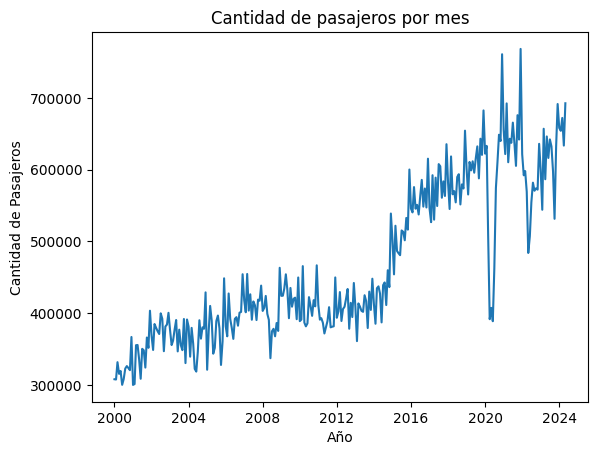

In [50]:
plt.plot(consume_data)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

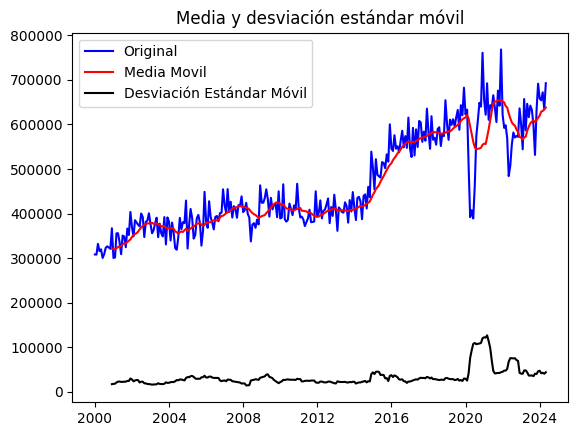

In [51]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = consume_data.rolling(window=12).mean()
deMovil = consume_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(consume_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

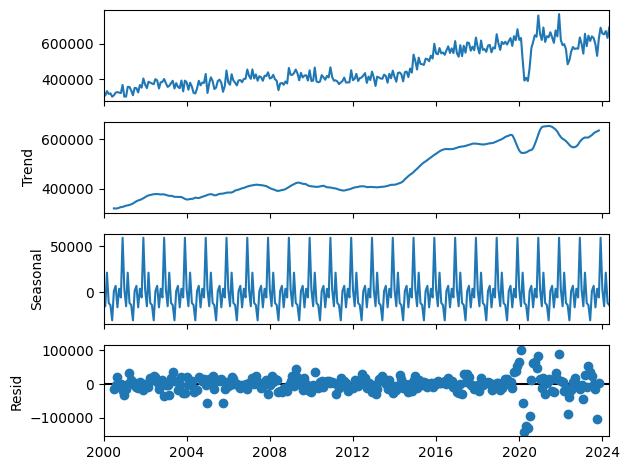

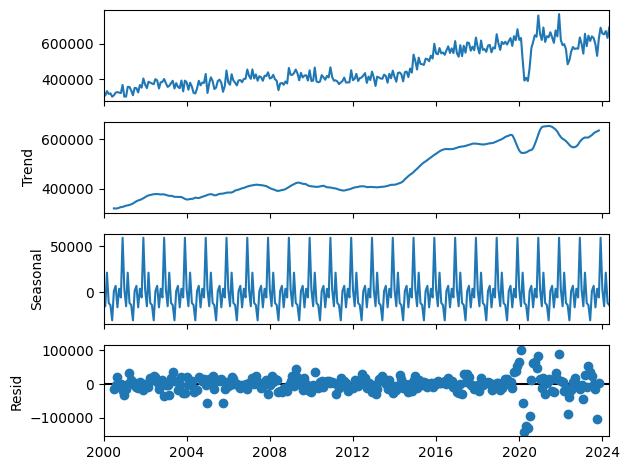

In [52]:
descomposicion = seasonal_decompose(consume_data, model='additive', period=12)
descomposicion.plot()

In [53]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consume_data, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.678783
p-value                        0.852169
# de retardos usados          12.000000
# de observaciones usadas    280.000000
Critical Value (1%)           -3.453922
Critical Value (5%)           -2.871918
Critical Value (10%)          -2.572300
dtype: float64


In [54]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
consume_data_diff = consume_data.diff()
consume_data_diff.fillna(0,inplace=True)
dfTest = adfuller(consume_data_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.675884
p-value                        0.000093
# de retardos usados          16.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


In [55]:
scaler = StandardScaler()
consume_data_scaled = scaler.fit_transform(consume_data_diff) 
consume_data_scaled[1:7]


array([[-0.04017635],
       [ 0.53896422],
       [-0.41483037],
       [ 0.06393185],
       [-0.48701636],
       [ 0.156897  ]])

In [56]:
entrenamiento = round(0.6*len(consume_data_scaled))
val_prueba = round(0.2*len(consume_data_scaled))
test = consume_data_scaled[(entrenamiento+val_prueba)-1:]
validation = consume_data_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = consume_data_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

59

In [57]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [58]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

In [59]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso, caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [61]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 0.5548 - val_loss: 1.0229
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.5468 - val_loss: 1.0060
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.5408 - val_loss: 0.9910
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.5352 - val_loss: 0.9741
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.5289 - val_loss: 0.9552
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 0.5220 - val_loss: 0.9349
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.5147 - val_loss: 0.9138
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.5072 - val_loss: 0.8924
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.4999 - val_loss: 0.8711
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.4927 - val_loss: 0.8503
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.4859 - val_loss: 0.8302
Epoch 12/50
176/176 ━━━━━━━━━━

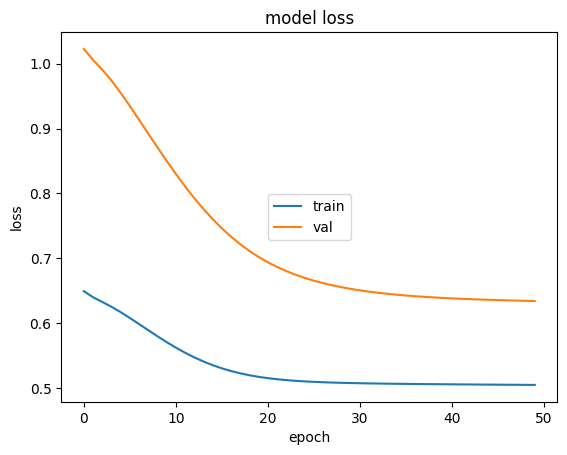

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [63]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.4809
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6437 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9857


1.8762147426605225

In [64]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
            # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consume_data.values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consume_data.values , n=entrenamiento+val_prueba)


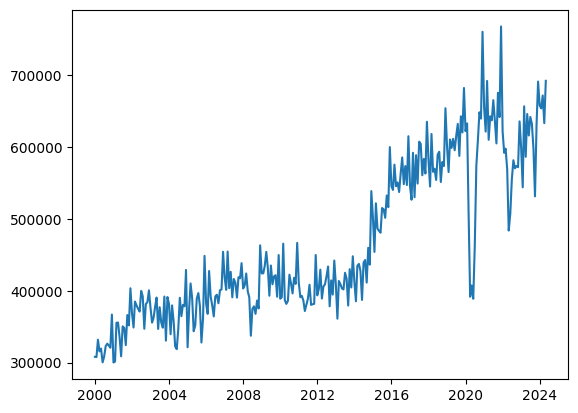

In [66]:
plt.plot(consume_data)

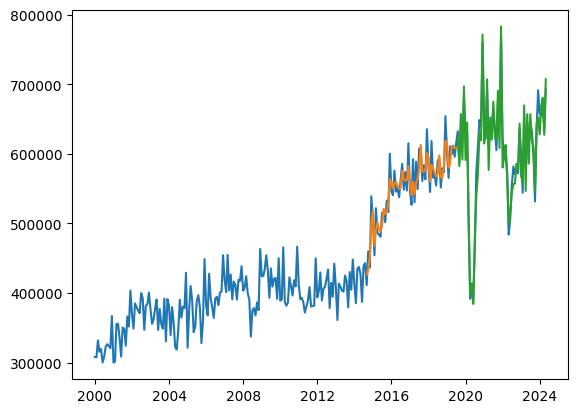

In [65]:
df_val = pd.DataFrame(prediccion_val,index=consume_data[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=consume_data[entrenamiento+len(df_val):len(consume_data)].index)


plt.plot(consume_data)
plt.plot(df_val)
plt.plot(df_test)